# **A forecast comparison of volatility models: evidence from some S&P500 stocks**

## 1. Introduction

Volatility is a central measure in finance. As of today, it is considered one if not the most important measure of market risk since it represents both the frequency with which a particular financial asset changes in price and the degree to which it changes in price. More generally, in everyday language it refers to the flucutuations of some phenomenon over time. More intuitively, if **everything** was known in advance, the price change every day would reflect only the time value of money, but because it is not and information has to be processed, priced in etc, the fluctuations in price represent the uncertainty and thus the risk.
As a consequence, the applications of volatility are numerous. Indeed, it plays an important role in various financial domains such as
- **risk management** for the computation of risk measures such as Value-at-Risk (VaR) and Expected Shortfall (ES).
- **asset allocations and portfolio management** where investors try to minimize the portfolio variance for a certain target portfolio return.
- **derivatives pricing**. One exemple is the pricing of options since volatility is one of the inputs of the famous Black and Scholes model.
- **investment strategies and hedging**. 

Although, volatility modelling finds its origin in finance, it has also proved to be extremely useful in other fields like in macroeconomics, electricity regulation, in weather forecasts and even in medicine. 

All these examples are the reason why forecasting volatility is crucial. 

Even though the forecasting of volatility has been the focus of a lot of empirical studies in academia, to do it accurately remains a challenge to this day. Therefore it is essential sometimes to test several models to find the one which is best-fitted to the situation. 

## 2. Objectives of this work

This work has several objectives. The first one is to study relevant methods for modelling the volatility of financial assets. The second objective is to make an extensive theoretical comparison of these different models. Foremost, answering certain questions such as:
- How do they work? 
- What is their relevant applications? 
- In which context? 

After that, the accuracy of our different models will be evaluated on real data (S&P500 component stocks), using the root mean squared errors (RMSE). The performance of each model will be then compared with each other in order to determine which one provides the best results.
To conclude this work, we will propose a concrete application of our forecasted volatility using our best model. This application will be a Value-at-Risk.


## 3. Dataset

In this work, we will be using historical data of the Standard & Poors 500 index. These data can be retrieved from the Yahoo finance website using the 
<code>yfinance</code> package. We will be downloading for 5 stocks chosen at random. The time period considered is exactly 1 year, from 2021-01-01 to 2021-12-31. 

### 3.1 Required packages and imports

In [1]:
import yfinance as yf # Source of financial data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pylab 
import scipy.stats as stats
import statsmodels.api as sm
import random as rd
from scipy.stats import moment
from colorama import Fore
from colorama import Style
from arch import arch_model
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import TimeSeriesSplit
from scipy.stats import norm
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import probplot, moment
from sklearn.svm import SVR
from scipy.stats import uniform as sp_rand

plt.rcParams["figure.figsize"] = (8, 5)

import warnings
warnings.filterwarnings('ignore')

### 3.2 Getting the data

In [2]:
def get_sp500_ticker_list():
    """
    Returns a list with all SP500 tickers
    """
    url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    tables = pd.read_html(url)
    table = tables[0]
    ticker_list = table['Symbol']
    return ticker_list

In [3]:
def get_sample_ticker(ticker_list, s=5):
    """
    Returns a list of s tickers chosen at random in the ticker_list
    """
    sample = ticker_list.sample(s, random_state = 1).to_list()
    return sample

In [4]:
def get_adj_close(ticker_list, start, end, interval):
    """
    Returns the adjusted close for a unique ticker as string or a list of tickers.
    Format of dates: 'yyyy-mm-dd'
    Possible intervals: '1d', '5d', '1mo' 
    or intraday measures but limited to max a week's worth: '1m', '2m', '5m', '15m', '30m'
    """
    full_df = yf.download(ticker_list, start=start, end=end, interval=interval)
    adj_close_df = np.log(full_df['Adj Close'])
    return adj_close_df

In [5]:
def get_adj_close_df(s=5, start='2021-01-01', end='2021-12-31', interval='1d', log = False):
    """
    Returns the returns df and adj close df for a unique ticker as string or a list of tickers.
    s = sample size
    Format of dates: 'yyyy-mm-dd'
    Possible intervals: '1d', '5d', '1mo' 
    or intraday measures but limited to max a week's worth: '1m', '2m', '5m', '15m', '30m'
    Returns a dataframe of a random sample of the sp500 adj closes over a certain period of time
    """
    sp500_tickers = get_sp500_ticker_list()
    sample_tickers = get_sample_ticker(sp500_tickers, s)
    full_df = yf.download(sample_tickers, start=start, end=end, interval=interval)
    if log == True:
        adj_close_df = np.log(full_df['Adj Close'])
    else:
        adj_close_df = full_df['Adj Close']
    return adj_close_df

In [6]:
def get_returns(adj_close_df):
    df_returns = (adj_close_df.pct_change())*100
    df_returns.dropna(axis=0,inplace=True)
    return df_returns

In [7]:
def get_volatility(returns_df):
    realized_vol = returns_df.rolling(5).std()
    realized_vol.dropna(inplace=True)
    return realized_vol

# 4. Data analysis

Before diving into the construction of our volatility models, it is important to get to know the data.

### 4.1 Adjusted closing price

In [8]:
adj_close_df = get_adj_close_df(s=5, start='2020-01-01', end='2021-12-31', interval='1d', log=True)

[*********************100%***********************]  5 of 5 completed


In [9]:
def plot_adj_close(adj_close_df, log=False):
    #plotting adjusted close price
    plt.plot(adj_close_df)
    plt.legend(adj_close_df.columns)
    if log == True:
        plt.title("Log Adjusted closing price of selected stocks")
    else:
        plt.title("Adjusted closing price of selected stocks")
    plt.show()

We decided to work on log adjusted-closing prices to narrow down scale differences and to get more stationary data. 

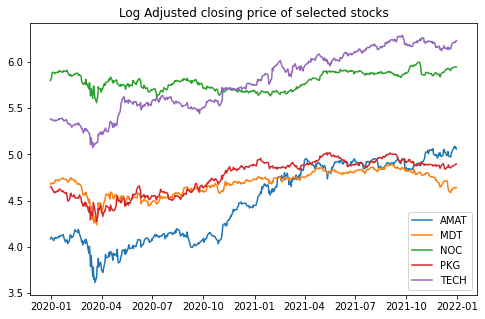

In [10]:
plot_adj_close(adj_close_df, log=True)

### 4.2 Log-returns

For practicality purposes, it is preferable to use the log returns instead of normal returns. In fact, it helps to remove the non-stationarity in the time series.

The log-returns are given by:
$r_{t,t+i} = ln(P_{t+i}/P_i)$

In [11]:
returns = get_returns(adj_close_df)
returns.head()

,AMAT,MDT,NOC,PKG,TECH
Date,,,,,
2020-01-02,0.460643,0.208014,0.578311,-0.245213,-0.004234
2020-01-03,-0.390791,-0.126929,0.906465,-0.293990,-0.236894
2020-01-06,-0.533087,0.188493,0.037115,-0.652992,0.041215
2020-01-07,0.700061,-0.074310,-0.038914,-0.231195,-0.101444
2020-01-08,-0.015854,0.371095,-0.213423,0.180218,-0.076094


In [12]:
def hurst(ts):
    """
    Returns the Hurst Exponent of the time series vector ts
    """
    # Create the range of lag values
    lags = range(2, 100)
    
    # Calculate the array of the variances of the lagged differences
    tau = [np.sqrt(np.std(np.subtract(ts[lag:], ts[:-lag]))) for lag in lags]
    
    # Use a linear fit to estimate the Hurst Exponent
    poly = np.polyfit(np.log(lags), np.log(tau), 1)
    
    # Return the Hurst exponent from the polyfit output
    return poly[0]*2.0

The **study of the distribution of the returns** might be an interesting metric. In a lot of financial models they are assumed to follow a Gaussian distribution. However, in practice it is rarely the case.  To this end, we have at our disposal several tools, like goodness-of-fit tests or graphical comparisons with theoretically known distributions. In this work, we will use the latter and more precisely a QQ-plot. 

A **QQ-plot** is a diagram which plots the quantiles of a theoretical distribution of interest (here Gaussian) against the quantiles observed in the data studied. If the quantiles match, then the observed data follow the theoretical distribution.

It is worth also inspecting the **partial autocorrelation function (PACF)** and the **autocorrelation function (ACF)** of the returns. It will help to estimate the number of lagged values that we need to incorporate later in our models.

All these metrics and diagnostic tools are defined in the function below. They are all summarized on the same plot.

In [13]:
def plot_correlogram(returns, lags=None, title=None):
    
    lags = min(10, int(len(returns)/5)) if lags is None else lags

    #plots layout
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

    #time series of return on top-left
    returns.plot(ax=axes[0][0])
    q_p = np.max(q_stat(acf(returns, nlags=lags), len(returns))[1])
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(returns)[1]:>11.2f} \nHurst: {round(hurst(returns.values),2)}'

    #adding stats on top-left plot
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)

    #plotting qqplot on top-right
    probplot(returns, plot=axes[0][1])

    #calculating distributions moments
    mean, var, skew, kurtosis = moment(returns, moment=[1, 2, 3, 4])
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'

    #adding stats on top-right plot
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)

    #plot autocorrelation
    plot_acf(x=returns, lags=lags, zero=False, ax=axes[1][0])
    axes[1][0].set_xlabel('Lag')

    #plot autocorrelation function
    plot_pacf(returns, lags=lags, zero=False, ax=axes[1][1])
    axes[1][1].set_xlabel('Lag')

    fig.suptitle(title, fontsize=20)
    fig.tight_layout()
    fig.subplots_adjust(top=.9)

To continue our data diagnostic. We are going to assess the stationarity of each return's time series. The Augmented-Dickey Fuller test is a statistical test which inspect if there is a unit root in the studied time series. Under H0, the have the presence of unit root, that is the series is non-stationary

In [14]:
def adf_test(returns):
    adfuller_results = adfuller(returns)
    
    print(Fore.BLUE + Style.BRIGHT + "ADF Test summary for "+ returns.name + Style.RESET_ALL)
    print(f'ADF Statistic:{adfuller_results[0]}')
    print(f'p-value: {adfuller_results[1]}')
    print('Critical Values:')
    for key, value in adfuller_results[4].items():
        print(f'{key}: {value:.4f}')

In [15]:
for i in range(0,len(returns.columns)):
    adf_test(returns.iloc[:,i])

ADF Test summary for AMAT
ADF Statistic:-8.708549592877329
p-value: 3.643729307442295e-14
Critical Values:
1%: -3.4436
5%: -2.8674
10%: -2.5699
ADF Test summary for MDT
ADF Statistic:-8.686536556250738
p-value: 4.148753904575753e-14
Critical Values:
1%: -3.4436
5%: -2.8674
10%: -2.5699
ADF Test summary for NOC
ADF Statistic:-6.02667653045531
p-value: 1.4503712924589085e-07
Critical Values:
1%: -3.4437
5%: -2.8674
10%: -2.5699
ADF Test summary for PKG
ADF Statistic:-7.332002374640937
p-value: 1.1215060857921819e-10
Critical Values:
1%: -3.4436
5%: -2.8674
10%: -2.5699
ADF Test summary for TECH
ADF Statistic:-6.692986562608172
p-value: 4.065221491254621e-09
Critical Values:
1%: -3.4437
5%: -2.8674
10%: -2.5699


As we can observe, the p-value of all the five tests are below the significance level at 99%. Therefore we can reasonably state that there are **no unit roots** in the time series of return. That's good news since we usually want stationary time series for forecasting.

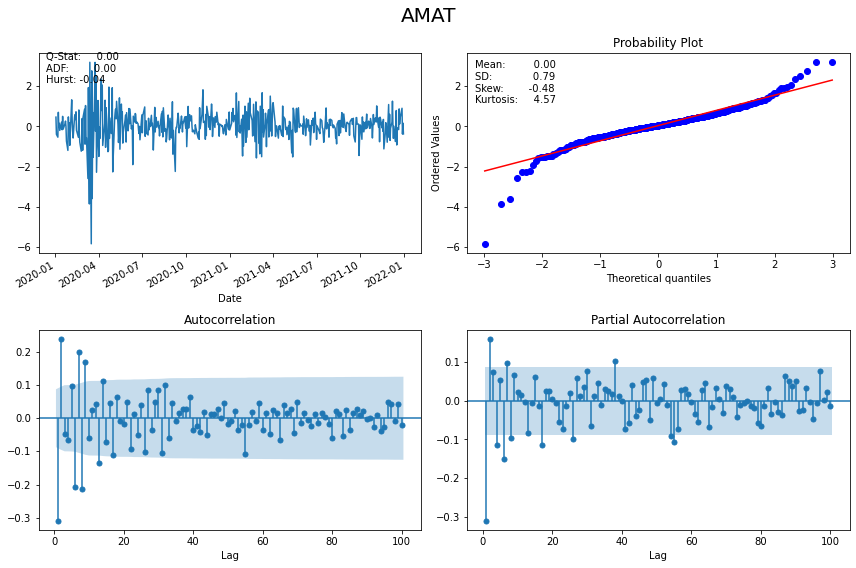

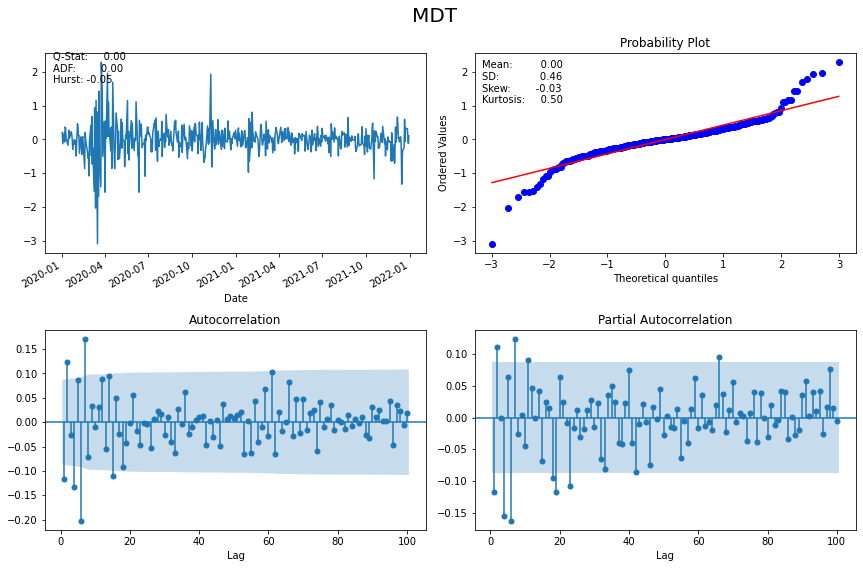

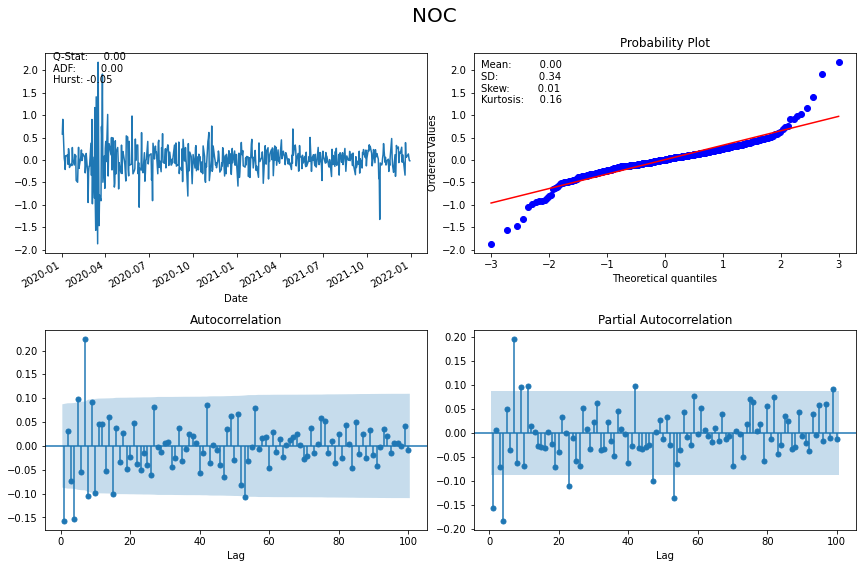

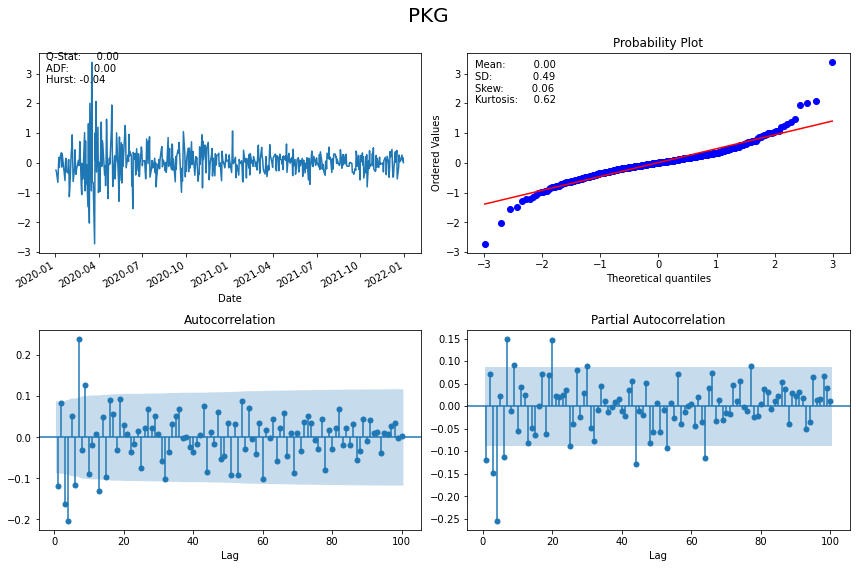

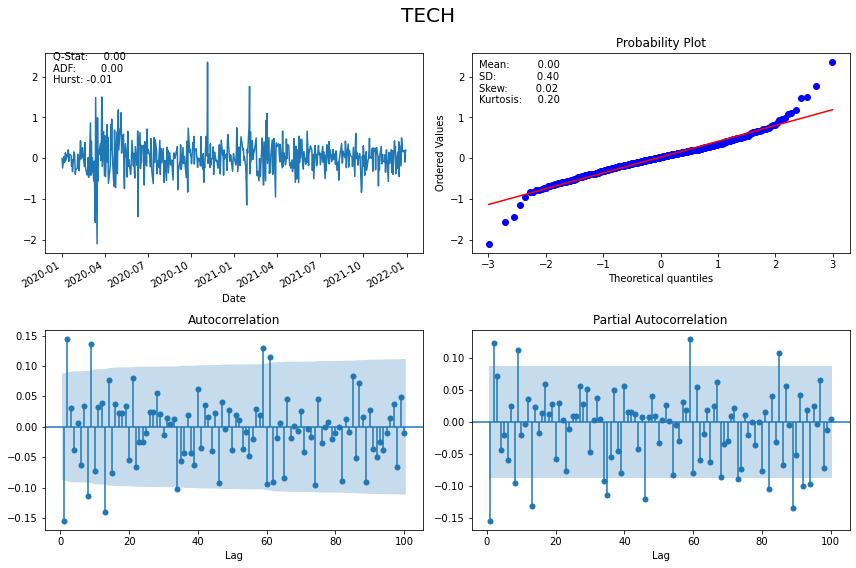

In [16]:
for i in range(len(returns.columns)):
    plot_correlogram(returns.iloc[:,i], lags=100, title=returns.iloc[:,i].name)

**Results of plot-correlogram function**

- As we thought, the different QQ-plots confirm that the time series of the returns is not normally distributed. Indeed, the distribution of the log-returns has fatter tails than the normal distribution. It means that extreme losses or very negative returns are more likely than under a complete normality assumption.
- In March 2020, a volatility cluster is observed on each return's time series. It was at the start of the COVID-19 pandemic. 
- For each series of returns, the lagged values in the autocorrelation function become non-significant before the 10th lags. (For computational resources purposes we will limit ourselves at 5 lags.
- After less than 5 lags, the partial autocorrelation function become also non-significant. However, we can notice that there are still big spikes in the lags after, meaning that the percentage changes are not totally serially independant.

In [17]:
def plot_ret_dist(returns, dist="normal"):
    #plotting histograms to inspect distribution of the returns. We can clearly see fatter tails
    plt.figure(figsize=(7,4))
    
    if dist == "student":
        sns.distplot(returns, norm_hist=True, fit=stats.t, bins=30, color='r')
        plt.legend(('student-t', 'returns'))
    elif dist == "normal":
        sns.distplot(returns, norm_hist=True, fit=stats.norm, bins=30, color='r')
        plt.legend(('normal', 'returns'))
    plt.show()

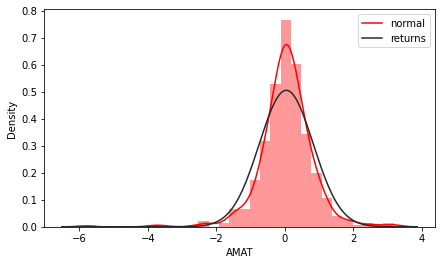

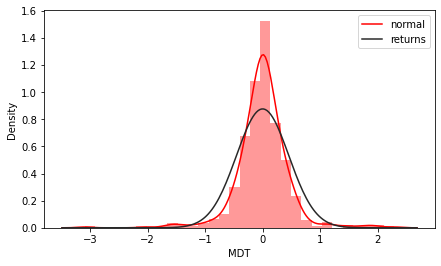

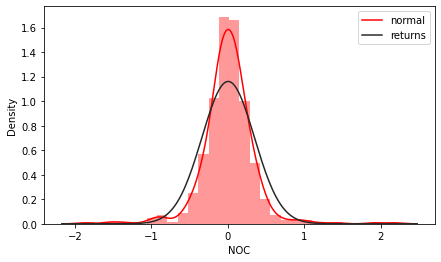

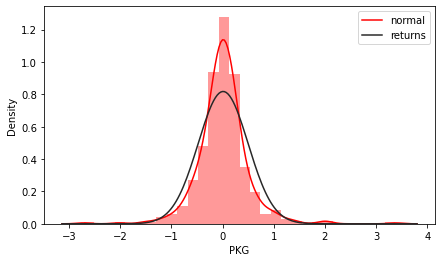

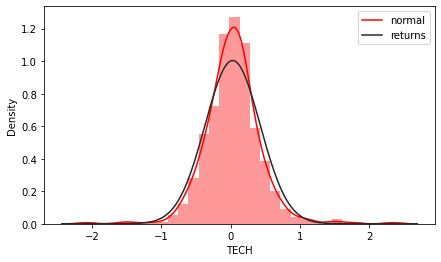

In [18]:
#evaluate return distribution with respect to a normal distribution
for i in range(len(returns.columns)):
    plot_ret_dist(returns.iloc[:,i], dist="normal")

Again these plots confirm our thoughts that the returns are not normally distributed and have clearly fatter tails

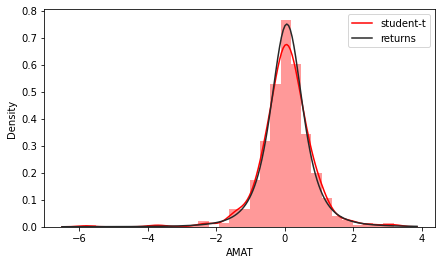

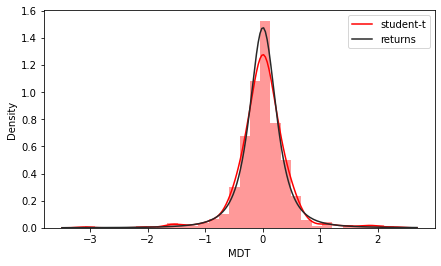

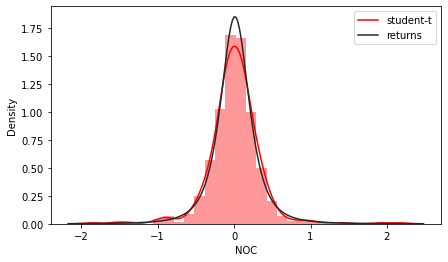

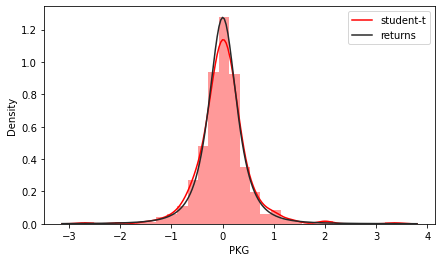

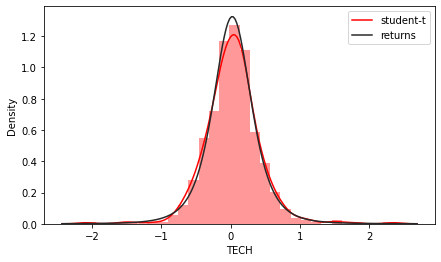

In [19]:
#evaluate return distribution with respect to a student distribution
for i in range(len(returns.columns)):
    plot_ret_dist(returns.iloc[:,i], dist="student")

Now if we evaluate the returns distribution with respect to a student distribution, the results are more conclusive. The two distributions are clearly closer. Therefore, it is reasonable to assume that our returns follow a student distribution. We will take this into account once building the volatility models. 

In [20]:
vol = get_volatility(returns)

### Splitting the dataset by observations

In [21]:
def split_df(df, n):
    df_test = df.iloc[-n:]
    df_train = df.iloc[:-n]
    split_date = df.iloc[-n:].index
    return df_train, df_test, split_date

In [22]:
# Cross validation
# tscv = TimeSeriesSplit(n_splits=20, test_size=5)
# def get_train_test(df):
#     train_test_indices = {'train':{}, 'test':{}, 'split_dates': {}}
#     for i, (train_index, test_index) in enumerate(tscv.split(df)):
#         train_test_indices['train'][i] = train_index
#         train_test_indices['test'][i] = test_index
#         train_test_indices['split_dates'][i] = test_index[0]
#     return train_test_indices
# returns_splits = get_train_test(returns_df)
# volatility_splits = get_train_test(volatility_df)

### ARMA

In [23]:
def arma(returns, n):
    aic_arma = []

    for p in range(1, 5): # Iterating AR parameters p and MA parameter q to find the best ones
        for q in range (1, 5):
            arma = ARIMA(returns, order=(p, 0, q)).fit()
            aic_arma.append(arma.aic) # Storing aic for the ARCH(p)

            if arma.aic == np.min(aic_arma): 
                best_param = (p, 0, q)

    arma = ARIMA(returns, order=best_param).fit()
    resids = arma.resid

    return resids

### GARCH

In [24]:
def garch(returns, n):
    aic_garch = []

    for p in range(1, 5): 
        for q in range(1, 5):
            garch = arch_model(returns, mean='zero', vol='GARCH', p=p, q=q, dist="skewt")\
                .fit(disp='off') 
            aic_garch.append(garch.aic) 

            if garch.aic == np.min(aic_garch): 
                best_param = (p,q) 
    
    #fitting the best GARCH model
    garch = arch_model(returns, mean='zero', vol='GARCH', p=best_param[0], q=best_param[1], dist="skewt").fit(disp='off')

    #forecasts
    forecasts = garch.forecast(horizon=n, reindex=False)
    #forecasts = garch.forecast(horizon=50, start=split_date[0], reindex=True)
    return forecasts, forecasts.residual_variance.dropna().transpose()

In [25]:
def get_rmse(residuals, realized_vol):
    rmse = np.sqrt(mse(realized_vol/100, np.sqrt(residuals/100)))
    return rmse

### ARCH

In [26]:
def arch(returns, n):
    aic_arch = []

    for p in range(1, 5): # Iterating ARCH parameter p
        arch = arch_model(returns, mean='zero', vol='ARCH', p=p)\
             .fit(disp='off') # Running ARCH(p)
        aic_arch.append(arch.aic) # Storing aic for the ARCH(p)

        if arch.aic == np.min(aic_arch): 
             best_param = p # Finding the minimum AIC score
                
    # Fitting best arch
    arch = arch_model(returns, mean='zero', vol='ARCH', p=best_param)\
         .fit(disp='off')
    
    forecasts = arch.forecast(horizon=n, reindex=False)
    
    return forecasts, forecasts.residual_variance.dropna().transpose()

### GJR garch

In [27]:
def gjr_garch(returns, n):
    aic_gjr_garch = []

    for p in range(1, 5): 
        for q in range(1, 5):
            gjr_garch = arch_model(returns, mean='zero', vol='GARCH', p=p, o=1, q=q)\
                 .fit(disp='off') 
            aic_gjr_garch.append(gjr_garch.aic) 

            if gjr_garch.aic == np.min(aic_gjr_garch): 
                 best_param = p, q # Finding the minimum AIC score
    
    gjr_garch = arch_model(returns, mean='zero', vol='ARCH', p=best_param[0], o=1,
                       q=best_param[1]).fit(disp='off')
    
    forecasts = gjr_garch.forecast(horizon=n, reindex=True)
    
    return forecasts, forecasts.residual_variance.dropna().transpose()

### EGARCH

In [28]:
def egarch(returns, n):
    aic_egarch = []

    for p in range(1, 5):
        for q in range(1, 5):
            egarch = arch_model(returns, mean='zero', vol='EGARCH', p=p, q=q)\
                  .fit(disp='off')
            aic_egarch.append(egarch.aic)
            if egarch.aic == np.min(aic_egarch):
                best_param = (p, q)
    
    egarch = arch_model(returns, mean='zero', vol='EGARCH',
                        p=best_param[0], q=best_param[1], dist="skewt").fit(disp='off')
    
    forecasts = egarch.forecast(horizon=n, method='simulation', reindex=False)
    
    return forecasts, forecasts.residual_variance.dropna().transpose()

### Neural Nets

#### A primer on Artificial Neural Networks

A **artificial neural network** is an interconnection of neurons such that their output is connected, with a weight, to the inputs of other neurons. The most common neural architecture is the **Multi-Layer Perceptron** (MLP). This is the one we used in this work.  
A MLP is composed of one (passthrough) **input layer**, one or more intermediate layers, called **hidden layers**, and one final layer called the **output layer**. When an ANN contains a several hidden layers, it is called a **deep neural network** (DNN). 

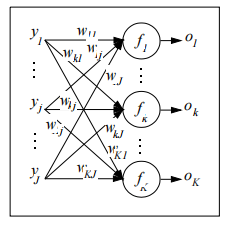

However, in our case, we will limit the theoretical presentation to a single hidden layer, because the deep neural case is just a generalisation to n-layers. 

In short an artificial neural network proceeds as follow:
- First, each neuron is fed some input. Each input is weighted by a weight $w_{kj} \quad \forall j \in \{1,...,J\}$ and $\forall k \in \{1,...,K\}$. 
- Then, the neuron acts like a processor and computes the sum of the inputs weighted.
$$ net_k = \sum_{j=1}^J w_{kj} y_j$$
- The output $o_k$ is then given by application of an activation function $ o_k = f_k(net_k)$

But, how are the optimal weights chosen?

The **error backpropagating** algorithm is currently the most popular learning algorithm. The backpropagation algorithm can find out how each connection weight and each term bias should be tweaked to reduce the error term. 

- For each training instance, the backpropagation algorithm first makes a prediction (forward pass) and measures the error
- It goes through each layer in reverse to measure the error contribution from each connection (backpropagation)
- Finally tweaks the connection weights to reduce the error using a Gradient steep descent.

In [29]:
def neural_net(Xs, n, NN_vol, para_grid_NN):
    X_predictions = {}
    for ticker, X in Xs.items():
        realized_vol = X[0]
        clf = RandomizedSearchCV(NN_vol, para_grid_NN)
        clf.fit(X.iloc[:-n].values,
            realized_vol.iloc[1:-(n-1)].values.reshape(-1, ))
        X_predictions[ticker] = clf.predict(X.iloc[-n:])
    return X_predictions

#### Neural nets & preprocessing

In [30]:
def get_svm_volatility(volatility_df):
    realized_vol = {}
    for ticker in volatility_df.columns:
        realized_vol[ticker] = pd.DataFrame(volatility_df[ticker]).reset_index(drop=True)
    return realized_vol

In [31]:
def get_svm_returns(returns_df):
    returns_svm = {}
    for ticker in returns_df.columns:
        returns_svm[ticker] = returns_df[ticker]**2
        returns_svm[ticker] = returns_svm[ticker].reset_index()
        del returns_svm[ticker]['Date']
    return returns_svm

In [32]:
def concat_ret_vol(returns_df, volatility_df):
    Xs = {}
    realized_vol = get_svm_volatility(volatility_df)#[:-4]
    returns_svm = get_svm_returns(returns_df)
    for ticker in volatility_df.keys():
        Xs[ticker] = pd.concat([realized_vol[ticker], returns_svm[ticker][:-4]], axis=1, ignore_index=True)
        
    return Xs

In [33]:
# def get_train_test_svm(Xs, n=50):
#     Xs_splitted = {}
#     for ticker, X in Xs.items():
#         Xs_splitted[ticker] = {}
#         Xs_splitted[ticker]['train'] = X.iloc[:-n]
#         Xs_splitted[ticker]['test'] = X.iloc[-n:]
#     return Xs_splitted

<!-- Xs_splitted = get_train_test_svm(Xs, n=50) -->

### RMSES

In [34]:
def get_rmses(s, n, start, end, interval):
    """
    s = how many companies
    n = sample size for testing
    """
    NN_vol = MLPRegressor(learning_rate_init=0.001, random_state=1)
    para_grid_NN = {'hidden_layer_sizes': [(100, 50), (50, 50), (10, 100)],
                'max_iter': [20000, 40000],
                'alpha': [0.00005, 0.0005 ]}
    rmses = {}
    
    # Get data
    adj_close_df = get_adj_close_df(s=s, start=start, end=end, interval=interval)
    
    # Get returns and volatility for arch type models
    returns_df = get_returns(adj_close_df)
    volatility_df = get_volatility(returns_df)
    
    # Splitting sets for arch type models
    df_train_vol, df_test_vol, split_date = split_df(volatility_df, n)
    df_train_ret, df_test_ret, split_date = split_df(returns_df, n)
    
    # Neural net preprocessing
    Xs = concat_ret_vol(returns_df, volatility_df)
    nn_predictions = neural_net(Xs, n, NN_vol, para_grid_NN)
    
    # Getting rmses
    for ticker in df_test_vol.columns:
        rmses[ticker] = {}
        
        #Neural net
        rmses[ticker]['nn'] = np.sqrt(mse(df_test_vol[ticker] / 100, nn_predictions[ticker] / 100))
        
        #Garch
        forecasts, residuals = garch(df_train_ret[ticker], n)
        rmses[ticker]['garch'] = get_rmse(residuals, df_test_vol[ticker])
        
        #Arch
        forecasts, residuals = garch(df_train_ret[ticker], n)
        rmses[ticker]['arch'] = get_rmse(residuals, df_test_vol[ticker])
        
        #GJR-garch
        forecasts, residuals = gjr_garch(df_train_ret[ticker], n)
        rmses[ticker]['gjr_garch'] = get_rmse(residuals, df_test_vol[ticker])
        
        #Egarch
        forecasts, residuals = egarch(df_train_ret[ticker], n)
        rmses[ticker]['egarch'] = get_rmse(residuals, df_test_vol[ticker])
        
    return rmses

In [35]:
# sample_daily_1y, adj_close_df = get_rmses(s=5, n=5, start='2017-01-17', end='2017-03-17', interval='1d')
# sample_daily_1y_df = pd.DataFrame(sample_daily_1y)
# sample_daily_1y_df.to_csv('sample_daily_1y.csv')
sample_daily_1y_df = pd.read_csv('sample_daily_1y.csv', index_col=0)
sample_daily_1y_df

,HUM,KEY,LNC,MOS,PYPL
nn,0.002382,0.001318,0.006900,0.000893,0.000773
garch,0.119689,0.116809,0.127331,0.128439,0.089246
arch,0.119689,0.116809,0.127331,0.128439,0.089246
gjr_garch,0.119688,0.126374,0.127390,0.182157,0.089250
egarch,0.200327,0.188522,0.218276,0.167622,0.348932


In [36]:
def plot_rmse(single_stock, e, title):
    if e == 0:
        models = ['Neural Net', 'Garch', 'Arch', 'Gjr-garch', 'Egarch']
        values = single_stock
    else:
        models = ['Neural Net', 'Garch', 'Arch', 'Gjr-garch']
        values = single_stock[:-1]
        
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.barh(models, values, color="salmon", alpha=0.9)
    plt.title(title)
    plt.show()

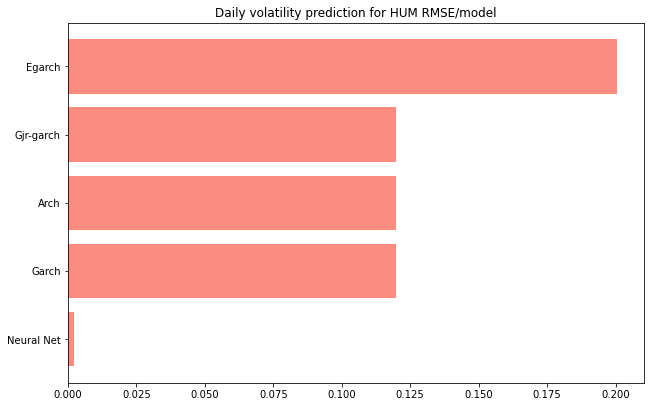

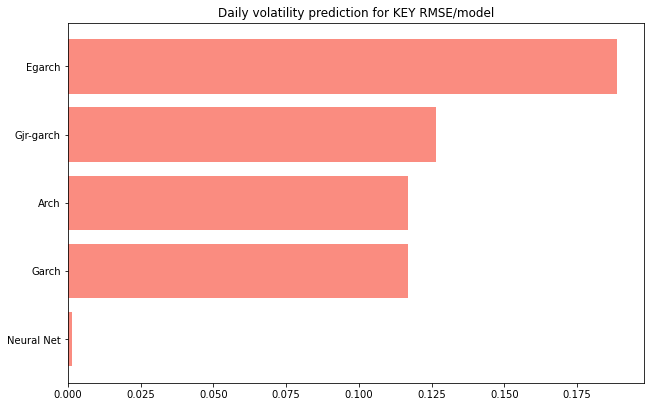

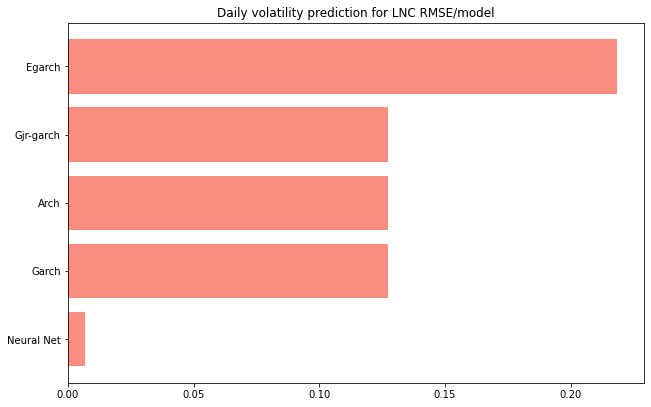

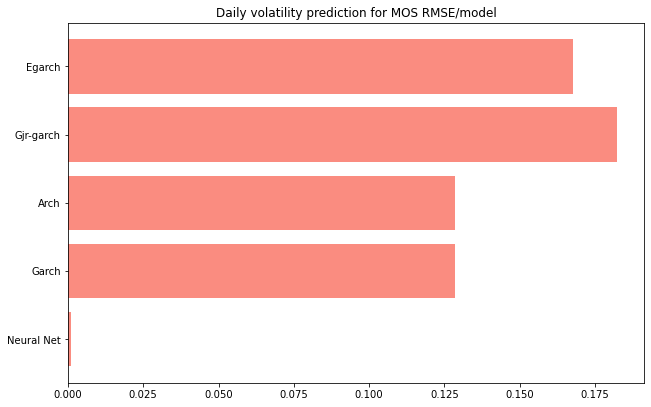

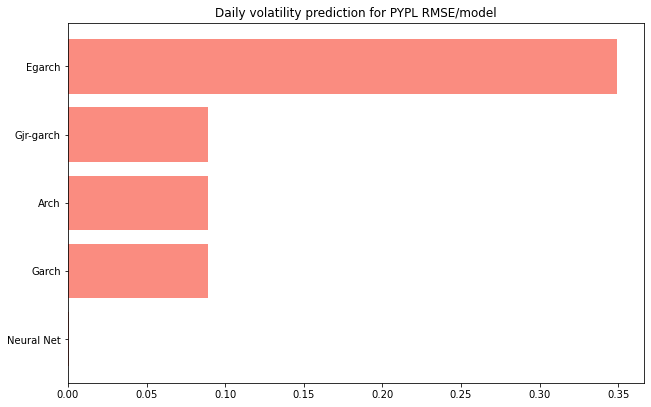

In [37]:
for ticker in sample_daily_1y_df.columns:
    plot_rmse(sample_daily_1y_df[ticker], 0, f'Daily volatility prediction for {ticker} RMSE/model')

We can clearly see that neural net has an insane performance compared to the other models. We can also notice that Garch and Arch have had the same performances on these returns so there is not much difference here. On the contrary E-garch and GJR-garch have very different performances as compared with arch and garch. GJR-garch is usually the worst except for the stock with ticker MOS.


To be fair we did not give the arch models a fair attempt at beating the neural net either because we did not fit an arma first to model the conditional mean and we did not allow our arch models more than 5 lags which as we have seen is probably is bit less than we should. Unfortunately our program would have been running for much too long.

In [38]:
sample_weekly_10y_df = pd.read_csv('sample_weekly_10y.csv', index_col=0)
sample_weekly_10y_df

,ADI,CPT,GL,RSG,V
nn,6.212129e-03,0.002598,0.002374,0.002115,0.005346
garch,3.577882e-01,0.443179,0.300571,0.347053,0.273248
arch,3.577882e-01,0.443179,0.300571,0.347053,0.273248
gjr_garch,2.682999e-01,0.229340,0.226870,0.183238,0.232233
egarch,2.032024e+08,32.045425,379.517528,249.148397,13.783146


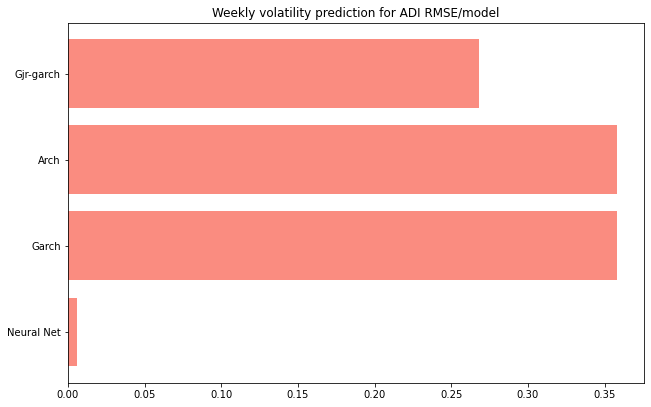

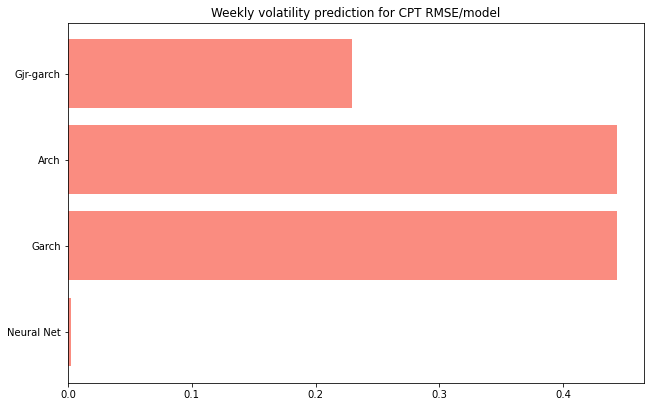

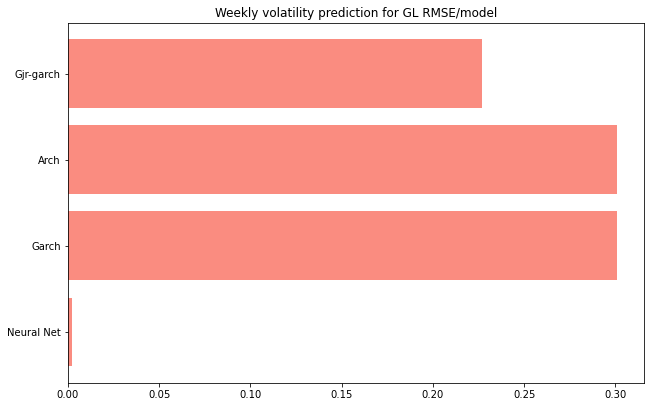

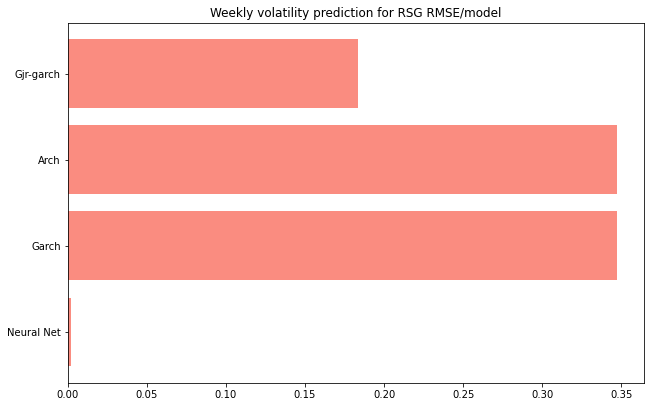

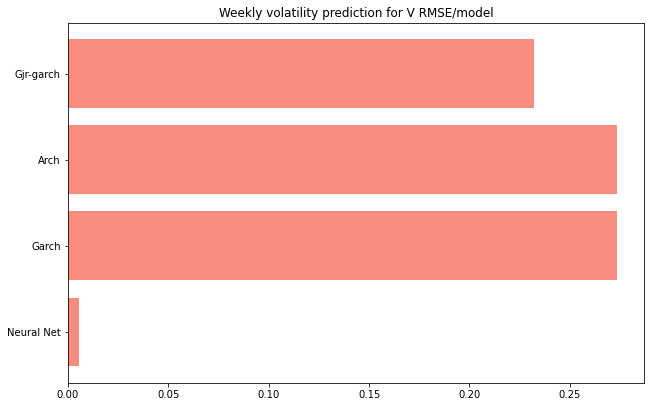

In [39]:
for ticker in sample_weekly_10y_df.columns:
    plot_rmse(sample_weekly_10y_df[ticker], 1, f'Weekly volatility prediction for {ticker} RMSE/model')

We can notice the same patterns as with the daily prediction but with one big difference, the performance of all models has decreased. This makes sense considering we fed our models less data and ask them to predict further ahead.

### Application

In [40]:
def var(s, n, start, end, interval, amount, level): 
    """
    s = how many companies
    n = sample size for testing
    """
    NN_vol = MLPRegressor(learning_rate_init=0.001, random_state=1)
    para_grid_NN = {'hidden_layer_sizes': [(100, 50), (50, 50), (10, 100)],
                'max_iter': [15000, 30000],
                'alpha': [0.00005, 0.0005 ]}
    rmses = {}
    
    # Get data
    adj_close_df = get_adj_close_df(s=s, start=start, end=end, interval=interval)
    
    # Get returns and volatility for arch type models
    returns_df = get_returns(adj_close_df)
    volatility_df = get_volatility(returns_df)
    
    # Splitting sets for arch type models
    df_train_vol, df_test_vol, split_date = split_df(volatility_df, n)
    df_train_ret, df_test_ret, split_date = split_df(returns_df, n)
    
    # Neural net preprocessing
    Xs = concat_ret_vol(returns_df, volatility_df)
    nn_predictions = neural_net(Xs, n, NN_vol, para_grid_NN)
    
    #Value at risk calculation
    var_dic = {}
    values = list(nn_predictions.values())
    i=0
    
    #a = np.random.random(s)
    #weights = a/(a.sum())
    
    for key in nn_predictions:
        var = norm.ppf(level)*(values[i][-1])/np.sqrt(100)*amount#*weights[i]
        var_dic[key] = var
        i=i+1
    
    plt.bar(range(len(var_dic)), list(var_dic.values()), align='center')
    plt.xticks(range(len(var_dic)), list(var_dic.keys()))
    plt.title("1% VaR of a 5-day horizon")
    plt.show()
    
    return var_dic

[*********************100%***********************]  5 of 5 completed


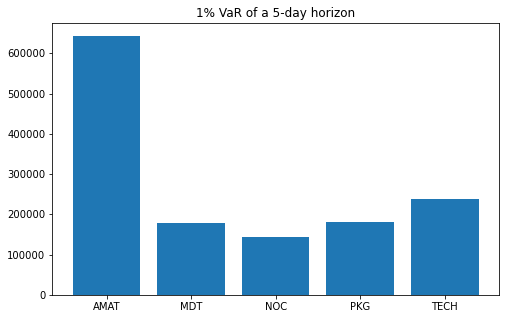

In [41]:
value_at_risk = var(s=5, n=5, start='2020-01-01', end='2021-12-31', interval='1d', amount=1000000, level=0.99)

As we can see here if an institution wants to reduce the VaR of its portfolio, it should prioritarily reduce the share of AMAT in their portfolio.

### BONUS: Comparing NN performance on different distributions

In [42]:
# Get data
def nn_vs_moments(s, n, start, end, interval):
    """
    Returns a dataframe with the rmse of the prediction with the neural network 
    and the moments of each stock's distribution
    """
    NN_vol = MLPRegressor(learning_rate_init=0.001, random_state=1)
    para_grid_NN = {'hidden_layer_sizes': [(100, 50), (50, 50), (10, 100)],
                'max_iter': [10000, 20000],
                'alpha': [0.00005, 0.0005 ]}
    
    adj_close_df = get_adj_close_df(s=s, start=start, end=end, interval=interval)
    
    # Get returns and volatility
    returns_df = get_returns(adj_close_df)
    volatility_df = get_volatility(returns_df)
    df_train_vol, df_test_vol, split_date = split_df(volatility_df, n)
    
    # Neural net preprocessing
    Xs = concat_ret_vol(returns_df, volatility_df)
    nn_predictions = neural_net(Xs, n, NN_vol, para_grid_NN)
    
    # Moments and rmse
    moments_rmses = {}
    for ticker in volatility_df.columns:
        moments_rmses[ticker] = {}
        moments_rmses[ticker]['rmse'] = np.sqrt(mse(df_test_vol[ticker] / 100, nn_predictions[ticker] / 100))
        moments_rmses[ticker]['mean'] = moment(volatility_df[ticker], moment=1)
        moments_rmses[ticker]['variance'] = moment(volatility_df[ticker], moment=2)
        moments_rmses[ticker]['skewness'] = moment(volatility_df[ticker], moment=3)
        moments_rmses[ticker]['kurtosis'] = moment(volatility_df[ticker], moment=4)
        
    return moments_rmses

In [43]:
# moments_rmses = nn_vs_moments(s=60, n=5, start='2017-01-17', end='2017-04-17', interval='1d')
# moments_rmses_df = pd.DataFrame(moments_rmses)
# moments_rmses_df.to_csv('moments_rmses.csv')
moments_rmses_df = pd.read_csv('moments_rmses.csv', index_col=0)

In [44]:
moments_rmses_df = moments_rmses_df.T

In [45]:
moments_rmses_df.head()

,rmse,mean,variance,skewness,kurtosis
ABC,0.000607,0.0,0.329546,0.251637,0.488376
ACN,0.001635,0.0,0.268439,0.293582,0.492926
ADI,0.000708,0.0,0.273348,0.170049,0.244018
ADM,0.001215,0.0,0.183979,0.115172,0.168559
AMCR,0.001900,0.0,0.323805,0.061878,0.155782


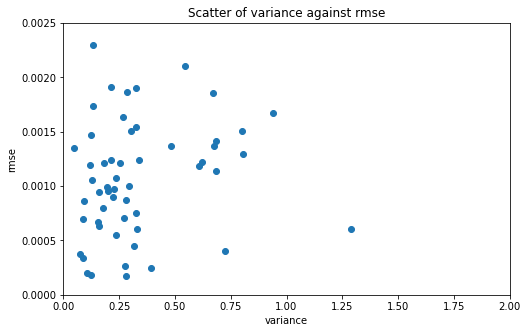

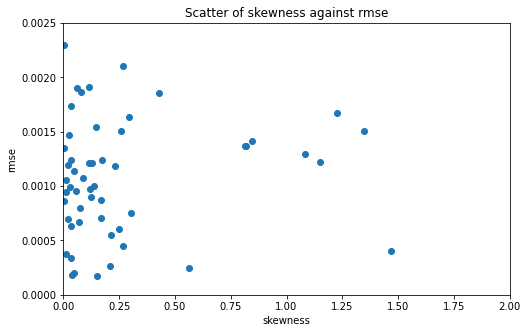

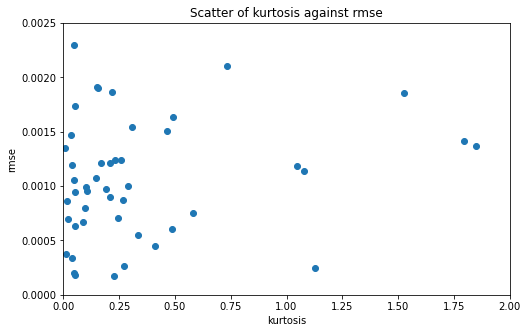

In [46]:
# Plot these tickers moments against the rmse
for column in ['variance', 'skewness', 'kurtosis']:
    plt.scatter(x=moments_rmses_df[column], y=moments_rmses_df['rmse'])
    plt.axis((0,2,0,0.0025))
    plt.xlabel(column)
    plt.ylabel('rmse')
    plt.title(f'Scatter of {column} against rmse')
    plt.show()

To conclude this bonus section:

Our neural network doesn't seem too bothered with the distribution of the returns. This makes sense considering how neural networks can fit very complex data.